# IMPORT

In [1]:
%matplotlib notebook
from utils.setup import *

# CREATION DATAFRAMES

In [2]:
train = pd.read_csv(TRAIN_MERGED, index_col=0)
train['ds'] = train.index
test = pd.read_csv(TEST_MERGED, index_col=0)

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

train.drop('Pseudo rayonnement', axis=1, inplace=True)
test.drop('Pseudo rayonnement', axis=1, inplace=True)

# PROPHET

In [3]:
import fbprophet

In [4]:
import holidays

hol = {'ds':[],'holiday':[]}

for date, name in sorted(holidays.FRA(years=list(range(2013,2020))).items()):
    hol['ds'].append(date)
    hol['holiday'].append(name)

french_holidays = pd.DataFrame(hol,columns=['ds','holiday'])
french_holidays.head()

,ds,holiday
0,2013-01-01,Jour de l'an
1,2013-04-01,Lundi de Pâques
2,2013-05-01,Fête du Travail
3,2013-05-08,Armistice 1945
4,2013-05-09,Ascension


In [5]:
%matplotlib inline

In [7]:
def prophet_feature(df_train, df_test, target):

    # Formating for prophet

    data = df_train[['ds', target]]
    data['y_orig'] = df_train[target]
    data.reset_index(inplace=True, drop=True)
    data.rename(columns={target:'y'}, inplace=True)
    data['y'] = np.log(data['y'] + 0.001) #log transform
    data.dropna(inplace=True)

    # Future Dataframe
    
    future = pd.DataFrame(pd.date_range(start=data.iloc[0]['ds'], end='2018-12-07', freq='30min'),columns=['ds'])

    # Prophet Model RES
    
    if target.startswith('R'):

        model = fbprophet.Prophet(changepoint_prior_scale=0.1)
        model.add_seasonality(name='demih',
                               period=1/48,
                               fourier_order=28)
            
    # Prophet Model PRO
    
    else:
        
        model = fbprophet.Prophet(changepoint_prior_scale=0.1,
#                                  seasonality_prior_scale=20
                                 daily_seasonality= 'auto',
                                 weekly_seasonality=10,
                                 yearly_seasonality= 8.7,
                                 )
        model.add_seasonality(name='demih',
                               period=1/48,
                               fourier_order=28)
#         model.add_seasonality(name='monthly',
#                               period=30.5,
#                               fourier_order=12)
#         model.add_seasonality(name='daily',
#                               period=1,
#                               fourier_order=15)
#         model.add_seasonality(name='weekly',
#                               period=7,
#                               fourier_order=20)
#         model.add_seasonality(name='yearly',
#                               period=365,
#                               fourier_order=20)
#         model.add_seasonality(name='quarterly',
#                               period=365/4,
#                               fourier_order=5)

        
    model.fit(data)
    forecast = model.predict(future) 


    # Unlog data

    forecast['yhat'] = np.exp(forecast['yhat']) - 0.001
    forecast['yhat_lower'] = np.exp(forecast['yhat_lower']) - 0.001
    forecast['yhat_upper'] = np.exp(forecast['yhat_upper']) - 0.001

    data['y_log'] = data['y']
    data['y'] = data['y_orig']

    # Predictions extraction

    trend = pd.DataFrame(forecast['yhat'].values, index=forecast['ds'].values, columns=['prophet_{}'.format(target)])
    trend.index = pd.to_datetime(trend.index)
    df_train = df_train.join(trend, how='outer')
    df_test = df_test.join(trend, how='outer')

    # Plot predictions

    plt.figure()
    plt.title(target)
    df_train[target].plot(label='Truth')
    forecast.set_index(forecast['ds'].apply(pd.to_datetime))['yhat'].plot(alpha=0.5, label='Pred')
    plt.legend()
    plt.show()
    
    print('RMSE : ', np.sqrt((df_train[target]-df_train['prophet_{}'.format(target)])**2).mean())

    return df_train, df_test

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib64/python3.5/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __nam

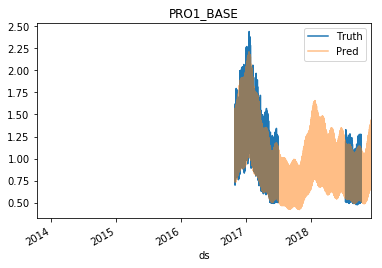

RMSE :  0.0786239262453661


(                       IDS      Horodate_UTC  Mois  Injection RTE (W)  \
 2013-10-13 00:00:00  961.0  02/11/2013 22:00  11.0       3.820834e+10   
 2013-10-13 00:30:00  962.0  02/11/2013 22:30  11.0       3.807833e+10   
 2013-10-13 01:00:00  963.0  02/11/2013 23:00  11.0       3.660017e+10   
 2013-10-13 01:30:00  964.0  02/11/2013 23:30  11.0       3.399954e+10   
 2013-10-13 02:00:00  965.0  03/11/2013 00:00  11.0       3.319009e+10   
 2013-10-13 02:30:00  966.0  03/11/2013 00:30  11.0       3.249878e+10   
 2013-10-13 03:00:00  967.0  03/11/2013 01:00  11.0       3.187939e+10   
 2013-10-13 03:30:00  968.0  03/11/2013 01:30  11.0       3.020060e+10   
 2013-10-13 04:00:00  969.0  03/11/2013 02:00  11.0       2.889847e+10   
 2013-10-13 04:30:00  970.0  03/11/2013 02:30  11.0       2.785915e+10   
 2013-10-13 05:00:00  971.0  03/11/2013 03:00  11.0       2.736066e+10   
 2013-10-13 05:30:00  972.0  03/11/2013 03:30  11.0       2.706151e+10   
 2013-10-13 06:00:00  973.0  03/11/201

limit_output extension: Maximum message size of 10000 exceeded with 168970 characters

In [8]:
 prophet_feature(train, test, 'PRO1_BASE')

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib64/python3.5/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __nam

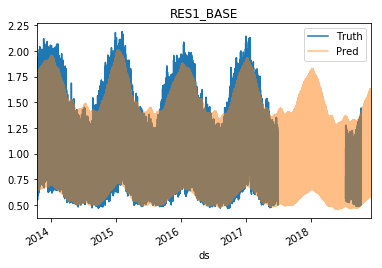

RMSE :  0.07674394345755398


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib64/python3.5/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __nam

In [ ]:
for tar in TARGETS:    
    train, test = prophet_feature(train, test, tar)

In [14]:
train = train[~train['Injection RTE (W)'].isna()]
test = test[~test['Injection RTE (W)'].isna()]

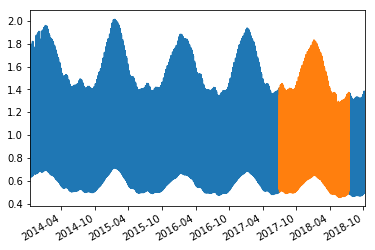

In [12]:
%matplotlib inline
plt.figure()
train['prophet_RES1_BASE'].plot()
test['prophet_RES1_BASE'].plot()
plt.show()

In [18]:
SAVE_PROPHET = True

In [19]:
if SAVE_PROPHET:
    pd.DataFrame.to_csv(train, 'train_prophet.csv')
    pd.DataFrame.to_csv(test, 'test_prophet.csv')

# Features Creation

In [22]:
def corr_drop(df,threshold, target, inf=0):
    
    df = df.copy()
    features = BASIC_FEAT.copy()
    features.append(target)
    df = df[features]
    corr_target = dict.fromkeys((features))
    to_drop = []
    
    for k in features:
        corr_target[k] = np.corrcoef(df[k],df[target])[0,1]
        if abs(corr_target[k])<inf:
            to_drop.append(k)
    
    for i in features:
        for j in features:
            if i !=j:
                if abs(np.corrcoef(df[i],df[j])[0,1])>threshold:
                    coefi, coefj = abs(corr_target[i]),abs(corr_target[j])
                    if coefi > coefj:
                        to_drop.append(j)
                    else:
                        to_drop.append(i)
                        
    to_drop = list(set(to_drop))
    print('Number of columns to drop : ',len(to_drop))
    print('Name of columns to drop :')
    for col in to_drop:
        print(col)
    return to_drop